# Aprendizaje automático en visión por computadoras
## Laboratorio 1: matching y estimación de transformaciones

In [20]:
import numpy as np
import cv2

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize']=18, 13

import warnings
warnings.simplefilter('ignore')

np.random.seed(12345)

En este lab abordaremos el problema de matching de características para la estimación de transformaciones entre imágenes. Para ello, trabajaremos en base a la secuencia graffitti ([link](http://www.robots.ox.ac.uk/~vgg/research/affine/index.html)) para la cual se proveen las transformaciones (homografías) entre cada par de imágenes. Este "ground truth" servirá para verificar las soluciones obtenidas.

Se asume que los archivos de la secuencia se encuentran en el mismo path del notebook. Caso contrario, adaptarlos según corresponda. Para el desarrollo del lab, se recomienda usar OpenCV 4.0 o superior. Para instalarlo se puede hacer:

```shell
$ pip3 install opencv-python --user
$ pip3 install opencv-contrib-python --user
```

o consultar las [guías de instalación](https://www.pyimagesearch.com/opencv-tutorials-resources-guides/) de pyimagesearch. La documentación para la versión 4.0 de OpenCV se puede consultar [acá](https://docs.opencv.org/4.0.0/index.html).

Para facilitar la visualización, se provee la función imshow2 la cual toma como argumentos dos imágenes y las grafica una al lado de la otra. Opcionalmente se puede pasar una matriz que representa la homografía de la primera a la segunda imagen, en cuyo caso se realiza la transformación de la primera y se sobreimpone sobre la segunda utilizando un factor de blending "alpha" ajustable (defult: 0.5). Lo mismo sucede con la versión transformada de la segunda sobre la primera utilizando la inversa de la transformación. 
A continuación se muestra un ejemplo empleando dos imágenes de la secuencia.

Homografía:
[[ 7.6285898e-01 -2.9922929e-01  2.2567123e+02]
 [ 3.3443473e-01  1.0143901e+00 -7.6999973e+01]
 [ 3.4663091e-04 -1.4364524e-05  1.0000000e+00]]


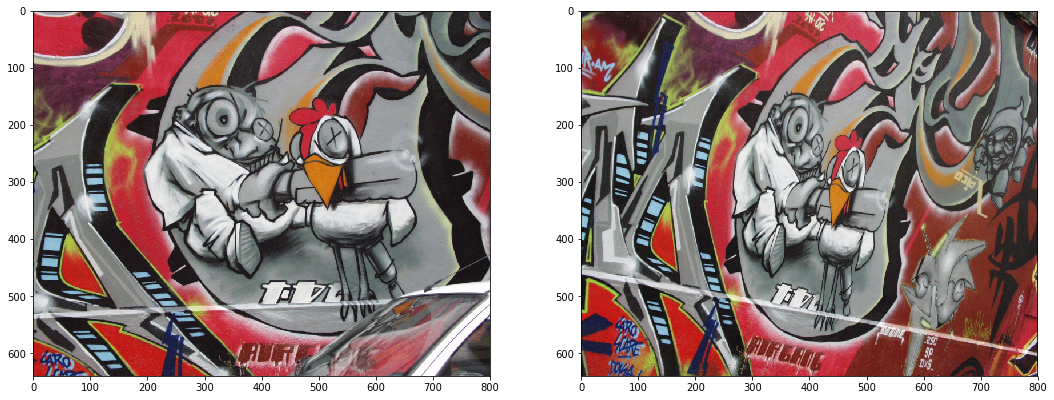

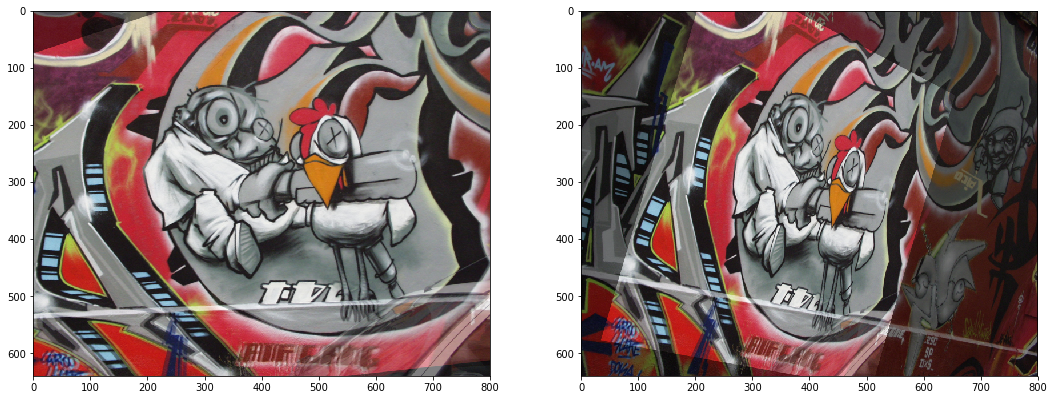

In [23]:
def imshow2(img1, img2, H1_2=None, alpha=0.5):
    if H1_2 is not None:
        H2_1 = np.linalg.inv(H1_2)

        img2_1 = cv2.warpPerspective(img2, H2_1, (img1.shape[1], img1.shape[0]))
        img1_2 = cv2.warpPerspective(img1, H1_2, (img2.shape[1], img2.shape[0]))
        
        img1 = np.clip(alpha * img2_1 + (1-alpha) * img1, 0., 255.)
        img1 = img1.astype(np.uint8)
        
        img2 = np.clip(alpha * img1_2 + (1-alpha) * img2, 0., 255.)
        img2 = img2.astype(np.uint8)

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
# Ejemplo 
img1 = cv2.imread('./img1.ppm')
img2 = cv2.imread('./img3.ppm')
H = np.loadtxt('./H1to3p')  # homografía de 1 a 3

imshow2(img1, img2)
print("Homografía:")
print(H)
imshow2(img1, img2, H)

# 1. Extracción de características locales

OpenCV provee una interfaz unificada para la detección y descripción de regiones. Al final de esta sección se brindan se listan distintas alternativas para la selección de detectores y descriptores de regiones. Nótese que algunos algortimos proveen tanto la funcionalidad de detección como la de descripción (p.ej. SIFT).

In [25]:
# Definir detector y descriptor

# detector = cv2.xfeatures2d.HarrisLaplaceFeatureDetector_create()
# descriptor = cv2.xfeatures2d.SIFT_create()

detector = cv2.xfeatures2d.SURF_create()
descriptor = detector

# Conversión BGR a escala de grises
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detectar regiones de interés en cada imagen. 
keypoints1 = detector.detect(gray1, None)
keypoints2 = detector.detect(gray2, None)




Las variables keypoints1 y keypoints2 son el resultado de la detección en cada una de las imágenes, las cuales corresponden a listas de elementos de tipo [cv2.KeyPoint](https://docs.opencv.org/4.0.0/d2/d29/classcv_1_1KeyPoint.html) que contienen la información asociada a cada región (p.ej. ubicación, escala característica, orientación, etc.). Se puede generar una visualización de dicha información empleando la función drawKeypoints de la siguiente manera:

1439/1920 features


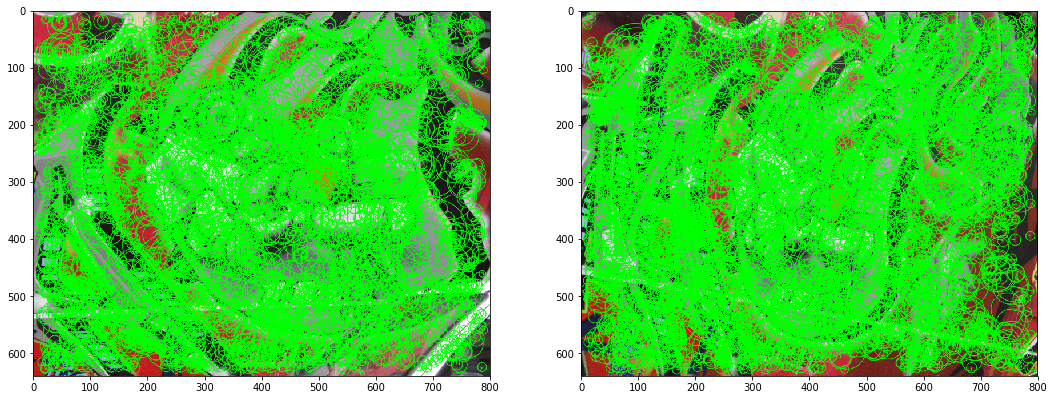

In [26]:
# visualización de keypoints
print("{}/{} features".format(len(descriptors1), len(descriptors2)))

visu1 = cv2.drawKeypoints(img1, keypoints1, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
visu2 = cv2.drawKeypoints(img2, keypoints2, np.array([]), (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imshow2(visu1, visu2)

Finalmente, empleando la información asociada a cada keypoint detectado en el paso anterior, es posible la normalización de las regiones (entornos locales) y el posterior cómputo de descriptores.

In [28]:
# Computar descriptores en torno a las regiones detectadas en el paso anterior
keypoints1, descriptors1 = descriptor.compute(img1, keypoints1)
keypoints2, descriptors2 = descriptor.compute(img2, keypoints2)

N1 = descriptors1.shape[0]
N2 = descriptors2.shape[0]
D = descriptors1.shape[1]
print("{}/{} descriptores de dimensionalidad {}".format(N1, N2, D))

4796/5588 descriptores de dimensionalidad 64


## Actividades: 

1. Familiarizarse con la documentación y métodos asociados a la detección y descripción de regiones con OpenCV
1. Analizar los niveles de invarianza de al menos 2 detectores además de HarrisLaplace

A continuación se brinda una lista parcial de algunos algoritmos de detección y/o descripción disponibles:

* BRISK: detector + descriptor
* ORB: detector + descriptor
* MSER: detector
* FAST: detector
* AGAST: detector
* GFFT: detector
* SimpleBlobDetector: detector
* KAZE: detector + descriptor
* AKAZE: detector + descriptor
* FREAK: descriptor
* StarDetector: detector
* BriefDescriptorExtractor: descriptor
* LUCID: descriptor
* LATCH: descriptor
* DAISY: descriptor
* MSDDetector: detector
* SIFT: detector + descriptor
* SURF: detector + descriptor

La lista completa para cada versión de OpenCV se puede consultar [acá](https://docs.opencv.org/4.0.0/d5/d51/group__features2d__main.html) y [acá](https://docs.opencv.org/4.0.0/d1/db4/group__xfeatures2d.html).

# 2. Cómputo de correspondencias

En esta sección utilizaremos los pares detector-descriptor obtenidos en la sección anterior para poder establecer correspondencias entre regiones de dos imágenes. 

0 matching pairs for a threshold of 0.08


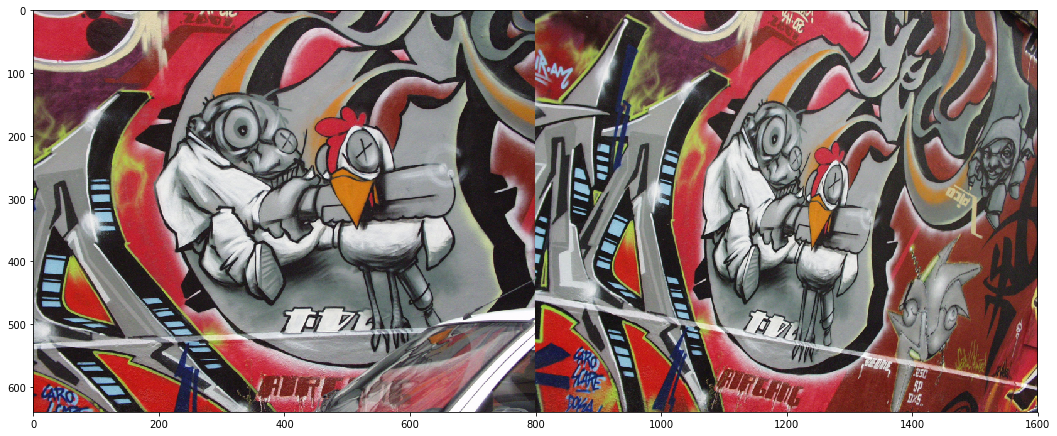

In [44]:
def compute_matches(desc1, desc2, distance_thresh=0.1):
    """
    función que toma como argumentos dos matrices de descriptores
    y, para cada desctiptor en la primera, establece posibles 
    correspondencias con los de la segunda. Para ello se utiliza 
    un umbral (distance_thresh) sobre la distancia euclidea entre
    descriptores. La función retorna una lista de pares de índices
    entre los descriptores marcados como correspondientes en la 
    primera y segunda imagen.
    """
    N1 = len(desc1)
    N2 = len(desc2)
    '''
    matching_pairs = []
    for i in range(N1):
        for j in range(N2):
            d = np.linalg.norm(desc1[i] - desc2[j])
            if d < distance_thresh:
                matching_pairs.append((i, j))
    return matching_pairs
    '''
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(desc1, desc2, metric='euclidean')
    print (distance_matrix)
#     i, j = np.where(distance_matrix < distance_thresh)
#     matching_pairs = list(zip(i, j))
    matching_pairs = []
    for i in range(N1):
        idxs = np.where(distance_matrix[i] < distance_thresh)[0]
        matching_pairs += [(i, j) for j in idxs]

    return matching_pairs

def compute_matches_ratio(desc1, desc2, distance_thres):    
#     """
#     Implementar el criterio de Lowe (umbral a la razón de distancias
#     entre el segundo y primer descriptor más próximo)
    
#     Tip: la función np.argsort(M, axis=1) retorna los índices 
#     que ordenan (de manera ascendente) las filas de la matrix M.
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(desc1, desc2, metric='euclidean')
    matching_pairs = []
    for i in range(len(desc1)):
        row = distance_matrix[i]
        best_idx, second_best_idx = np.argsort(row)[:2]
        if row[best_idx] < distance_thresh * row[second_best_idx]:
            matching_pairs.append((i, best_idx))
    return matching_pairs


# ajustar la distancia máxima permitida entre descriptores
distance_thresh = 0.08

#matching_pairs = compute_matches(descriptors1, descriptors2, distance_thresh)
matching_pairs = compute_matches_ratio(descriptors1, descriptors2, distance_thresh)
print('{} matching pairs for a threshold of {}'.format(len(matching_pairs), distance_thresh))

keypoints1 = [keypoints1[i] for i, _ in matching_pairs]
keypoints2 = [keypoints2[j] for _, j in matching_pairs]

# visualización de correspondencias
N = len(keypoints1)
tile = np.hstack([img1, img2])  # pegar las imágenes lado a lado
for i in range(N):
    x1, y1 = int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1])
    # a las coordenadas de los puntos de la segunda imagen hay que sumarle
    # el ancho de la primera para que caigan donde corresponde en el tile
    x2, y2 = int(keypoints2[i].pt[0])+img1.shape[1], int(keypoints2[i].pt[1])
    cv2.line(tile, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.circle(tile, (x1, y1), 5, (0,255,0), 2)
    cv2.circle(tile, (x2, y2), 5, (0,255,0), 2)
plt.imshow(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))


## Actividades

1. Realizar un análisis cualitativo de las correspondencias obtenidas para distintos valores del umbral de distancia sobre los pares (img1, img2) e (img1, img3).
1. Implementar la función ```compute_matches_ratio```. Repetir el análisis del punto anterior empleando esta nueva función. Discutir sobre la unicidad de las correspondencias obtenidas mediante ambos criterios.

# 3. Estimación de transformaciones (I)

En esta sección abordaremos la estimación de transformaciones en el caso a partir de correspondencias "limpias", es decir, sin considerar el efecto de los outliers. Para ello, nos valdremos de las matrices H anotadas en la secuencia de test. Sin embargo, es conveniente familiarizarse con las coordenadas en ambos sistemas y sus transformaciones.

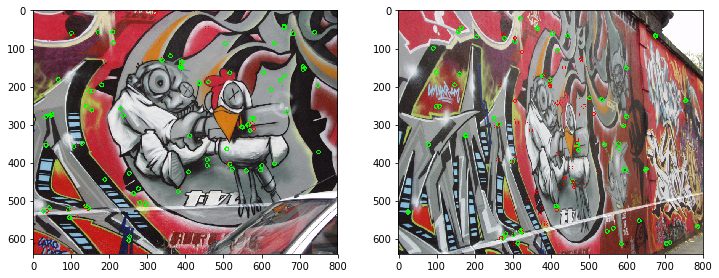

In [25]:
def c2h(p):
    # coordenadas cartesianas a homogéneas. Asume que p es una lista/ndarray de pares (x, y)
    return np.array([(x, y, 1) for x, y in p])

def h2c(p):
    # coordenadas homogéneas a cartesianas. Asume que p es una lista/ndarray de triplas (x, y, w)
    return np.array([(x/w, y/w) for x, y, w in p])

# coordenadas de los puntos en la imagen 1 (2) que tienen correspondencia en la imagen 2 (1)
p1 = np.array([keypoints1[i].pt for i, _ in matching_pairs])
p1h = c2h(p1)

p2 = np.array([keypoints2[j].pt for _, j in matching_pairs])
p2h = c2h(p2)

# proyección de los puntos de la imagen 2 en la 1
p1h_2 = H.dot(p1h.T).T
p1_2 = h2c(p1h_2)

# proyección de los puntos de la imagen 2 en la 1 mediante la inversa de H
Hinv = np.linalg.inv(H)
Hinv /= Hinv[2, 2]
p2h_1 = Hinv.dot(p2h.T).T
p2_1 = h2c(p2h_1)

# visualización
visu1 = img1.copy()
visu2 = img2.copy()
for i in range(len(matching_pairs)):
    # puntos en la imagen 1
    x, y = p1[i]
    cv2.circle(visu1, (int(x), int(y)), 5, (0,255,0), 2)
    
    # puntos de la imagen 2 proyectados en la 1
    x, y = p2_1[i]
    cv2.circle(visu1, (int(x), int(y)), 5, (0,0,255), 1)    

    # puntos en la imagen 2
    x, y = p2[i]
    cv2.circle(visu2, (int(x), int(y)), 5, (0,255,0), 2)
    
    # puntos de la imagen 1 proyectados en la 2
    x, y = p1_2[i]
    cv2.circle(visu2, (int(x), int(y)), 5, (0,0,255), 1)    

imshow2(visu1, visu2)

De la figura generada en el paso anterior se puede observar que algunas correspondecias son correctas (inliers) y otras no (outliers). Esto es posible porque conocemos H.

# Actividades

1. Implementar una función que tome como argumentos dos listas de puntos correspondientes de longitud N, una matriz de transformación en coordenadas homogéneas H y un valor de distancia umbral y retorne una lista de booleanos de longitud N indicando si los pares correspondientes son inliers (True) o outliers (False). Se entiende que un par es inlier bajo H si la el promedio de las distancias entre los puntos de una imagen y la proyección de los correspondientes en la otra es menor a un umbral preestablecido (reprojection_thresh)


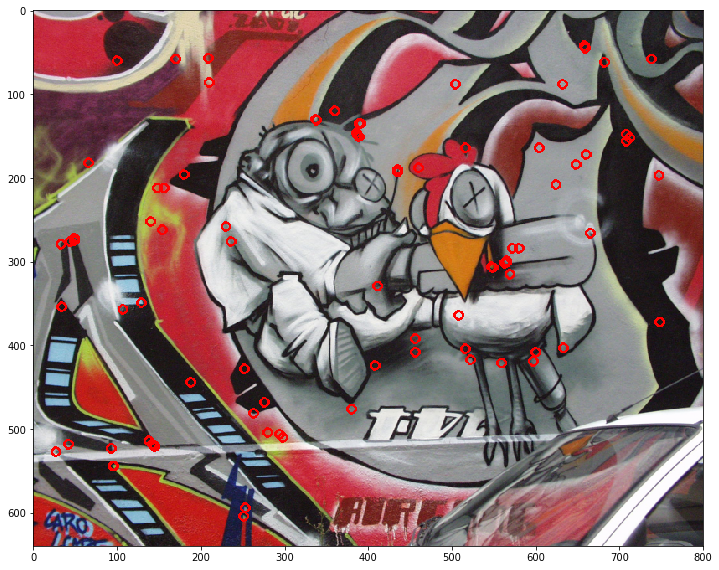

In [26]:
def check_inlier(p1, p2, H, reprojection_thresh):
    N = len(p1)
    assert N == len(p2)
    inliers = [False] * N
    
    # ...
    
    return inliers


reprojection_thresh = 5

is_inlier = check_inlier(p1, p2, H, reprojection_thresh)

visu1 = img1.copy()  # visualización sobre la imagen 1
for x, y in p1:           
    if is_inlier[i]:
        cv2.circle(visu1, (int(x), int(y)), 5, (0,255,0), 2)        
    else:        
        cv2.circle(visu1, (int(x), int(y)), 5, (0,0,255), 2)

plt.imshow(cv2.cvtColor(visu1, cv2.COLOR_BGR2RGB))

2. Implementar una función que tome como argumentos dos listas de puntos correspondientes de longitud N y retorne una estimación afín de la transformación entre ellos. Utilizar una solución en forma cerrada. La matriz retornada debe expresarse en coordenadas homogéneas (tamaño 3x3)

In [ ]:
def estimate_affine_transform(p1, p2):
    N = len(p1)
    assert N == len(p2)
    tr = np.eye(3)
    
    # ...
    
    return tr

p1_inliers = [p1[i] for i, b in enumerate(is_inlier) if b]
p2_inliers = [p2[i] for i, b in enumerate(is_inlier) if b]

A = estimate_affine_transform(p1_inliers, p2_inliers)

imshow2(img1, img2, A)

# Estimación de transformaciones (II)

Hasta ahora trabajamos sólo con los "inliers", valiéndonos de una homografía conocida. En la práctica no disponemos de esta información, por lo que necesitamos un método robusto de estimación. En esta sección implementaremos RANSAC para estimación de una transformación afin.

## Actividad

1. Implementar la función RANSAC que se da a continuación. La misma toma como argumentos dos listas de puntos de longitud N, una referencia a una función de estimación, el tamaño de la muestra a utilizar en cada iteración, el número de iteraciones y el márgen (error) permitido en la estimación de inliers/outliers.

In [ ]:
def RANSAC(p1, p2, estimator_fn, sample_size, n_iter=10000, margin=5):
    N = len(p1)    
    assert N == len(p2)
    assert N > sample_size
        
    models, consensus = [], []
    for _ in range(n_iter):
        # Generar una muestra de "sample_size" puntos, usando muestreo sin remplazo        
        # p1_sample = ...
        # p2_sample = ...
    
        # Estimar transformación usando la muestra generada y la función pasada como argumento (estimator_fn)
        tr = np.eye(3)
        
        # Computar inliers bajo la hipótesis actual, computar consenso y guardar
        # err = ...
        cons = 0
        
        models.append(tr)
        consensus.append(cons)
    
    # transformación con máximo consenso
    i = np.argmax(consensus)
    tr = models[i]

    # reestimar usando los "inliers" para esa transformación. Determinar los inliers en base al margen dado
    inliers = []
        
    return tr, np.mean(inliers)

A, err = RANSAC(p1, p2, estimate_affine_transform, 3)
print('estimation error (RANSAC inliers): {:.3f} [pixels]'.format(err))

imshow2(img1, img2, A)

3. Implementar una función para la estimación de homografías con la misma estructura de la correspondiente a afinidades. Utilizar la función RANSAC del punto anterior para obtener una estimación robusta de H. Comprarla con la matriz provista por la secuencia de referencia. 
5. Analizar y discutir la estimaciones de H para los pares (img1,img2), ..., (img1,img5) en cuanto al número de correspondencias y calidad de la estimación.

In [ ]:
def estimate_homography(p1, p2):    
    N = len(p1)
    assert N == len(p2)

    # TODO: Armar la matriz A en base a p1 y p2 (ver slides de clase)
    # A = ...
    
    # los vectores singulares por la derecha son los autovectores de A.T.dot(A)
    _, _, V = np.linalg.svd(A)
    tr = V[-1].reshape((3,3), order='C')     
    tr /= tr[2, 2]
    return tr

p1_inliers = [p1[i] for i, b in enumerate(is_inlier) if b]
p2_inliers = [p2[i] for i, b in enumerate(is_inlier) if b]
H_est = estimate_homography(p1_inliers, p2_inliers)
imshow2(img1, img2, H_est)

H_est, err = RANSAC(p1, p2, estimate_homography, 5)
print('estimation error (RANSAC inliers): {:.3f} [pixels]'.format(err))
imshow2(img1, img2, H_est)